In [1]:
from pathlib import Path
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Locations of files and folders

In [12]:
sites = ["US-Bi1", "US-Hn1", "US-Me2", "US-Whs"]
varns = ["LE", "NEE"]
cases = ["test-model", "PB-ML-0.5", "Hybrid-ML-0.5"]
subpara = [
    "ep",
    "par_reflect",
    "par_trans",
    "nir_reflect",
    "nir_trans",
    "bprime",
    "lleaf",
    "qalpha",
    "kball",
    "leaf_clumping_factor",
    "vcopt",
    "jmopt",
    "epsoil",
    "q10a",
    "q10b",
    "q10c",
]
subpara_labels = [
    "$\epsilon$",
    "$r_{PAR}$",
    "$\tau_{PAR}$",
    "$r_{NIR}$",
    "$\tau_{NIR}$",
    "$m$",
    "$g_0$",
    "$l$",
    "$\alpha$",
    "$\Omega$",
    "$V_{c,\max,25}$",
    "$J_{\max,25}$",
    "$\epsilon_{surf}$",
    "$a_r$",
    "$b_r$",
    "$c_r$",
]
varn_set = ["LE", "NEE"]

# Load the sensitivity result

In [10]:
df_sa_set = {}

for site in sites:
    dir_model = Path(f"{site}/")

    labels, df_sa_site = [], []
    for case in cases:
        dir_case = dir_model / case
        for varn in varn_set:
            f_sa = dir_case / f"sensitivity-{varn}.csv"
            df_sa = pd.read_csv(f_sa, index_col=0, parse_dates=True)
            df_sa_site.append(df_sa)
            labels.append(f"{varn}:{case}")
    df_sa_site = pd.concat(df_sa_site, axis=1, keys=labels)
    df_sa_set[site] = df_sa_site

# Ranking sensitivity

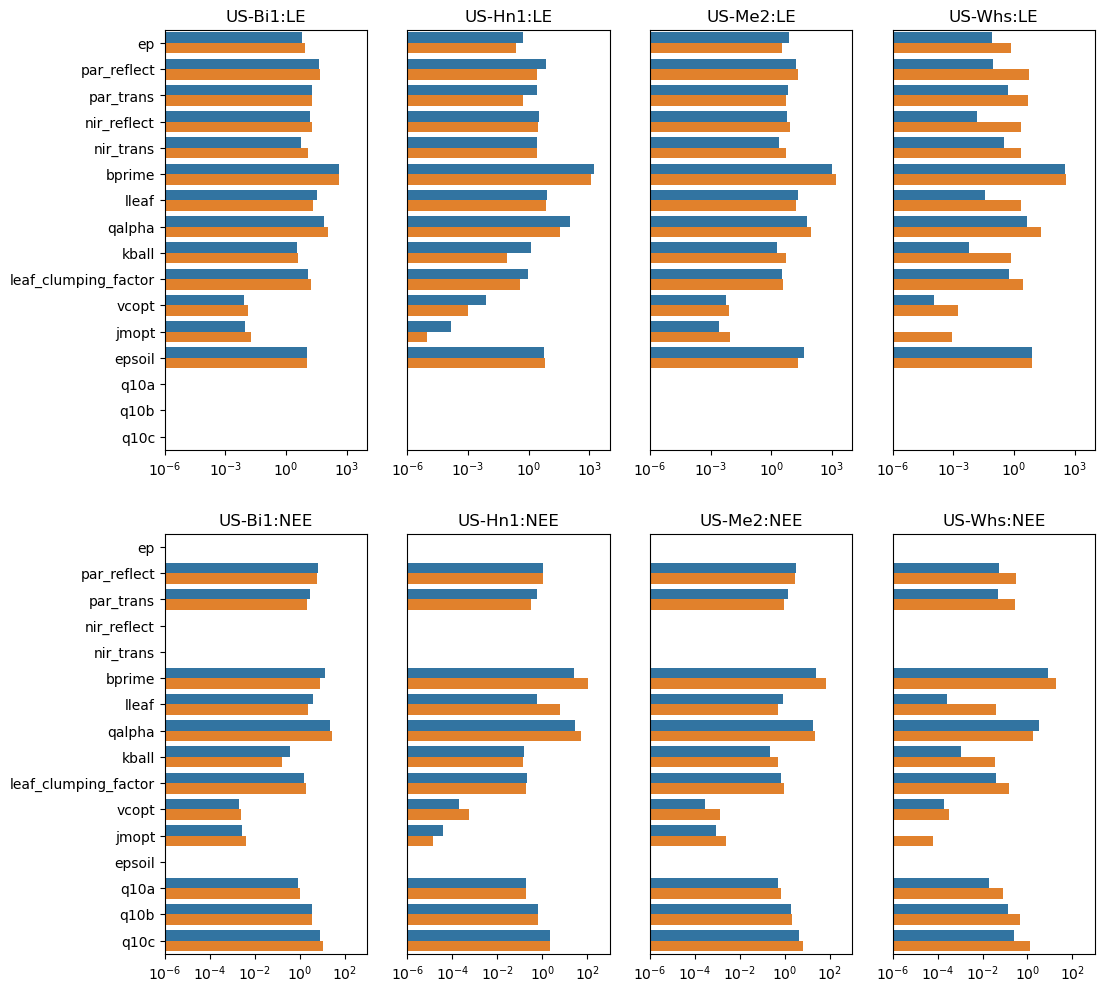

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(12, 12))
for j, site in enumerate(sites):
    for i, varn in enumerate(varn_set):
        ax = axes[i, j]
        df_sa = []
        for case in ["PB-ML-0.5", "Hybrid-ML-0.5"]:
            sa = df_sa_set[site][f"{varn}:{case}"][subpara].copy()
            sa[sa.abs() > 1e5] = np.nan
            sa.replace([np.inf, -np.inf], np.nan, inplace=True)
            d = sa.abs().mean()
            d = d.reset_index()
            d.columns = ["Para", "Derivative"]
            d["Case"] = case
            df_sa.append(d)
        df_sa = pd.concat(df_sa)
        # sns.barplot(df_sa, x="body_mass_g", y="island", hue="island", legend=False)
        sns.barplot(df_sa, y="Para", x="Derivative", hue="Case", ax=ax, legend=False)
        ax.set(ylabel="", xlabel="", title=f"{site}:{varn}", 
               xscale='log', xlim=[1e-6,1e4] if varn=='LE' else [1e-6,1e3])
        if j != 0:
            ax.set_yticks([])

# Directional Derivative

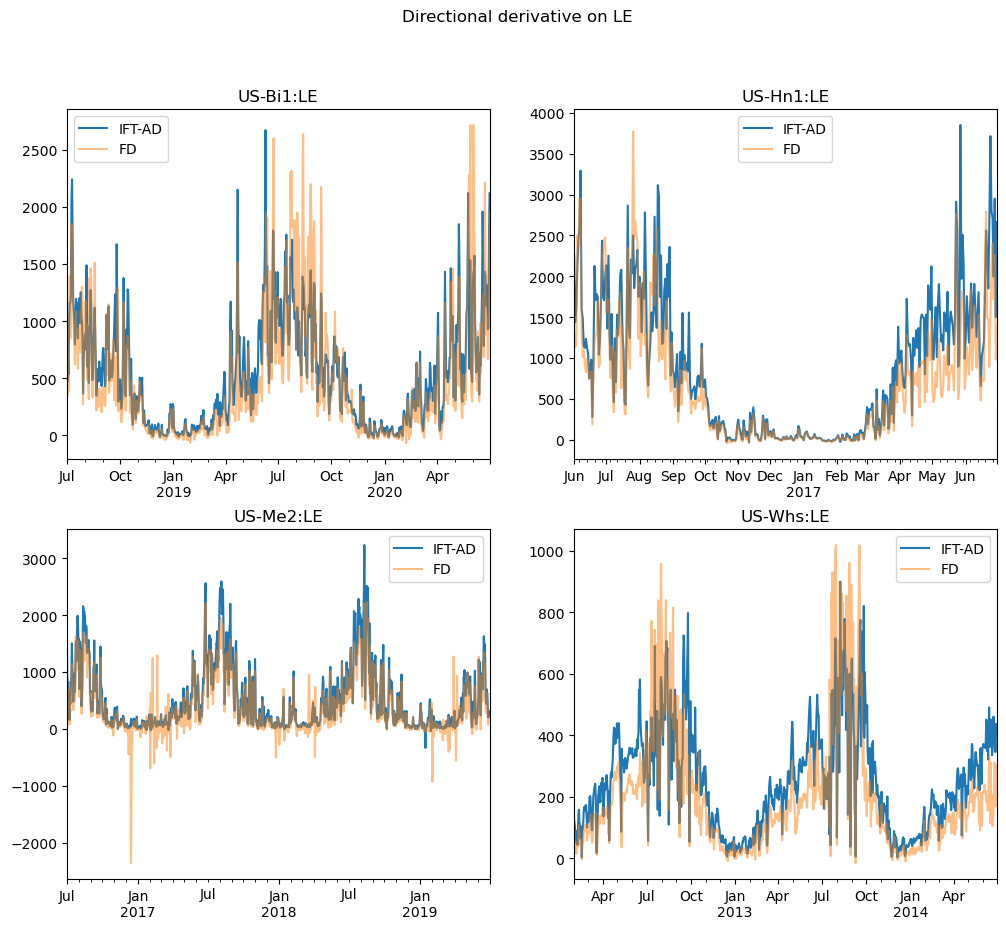

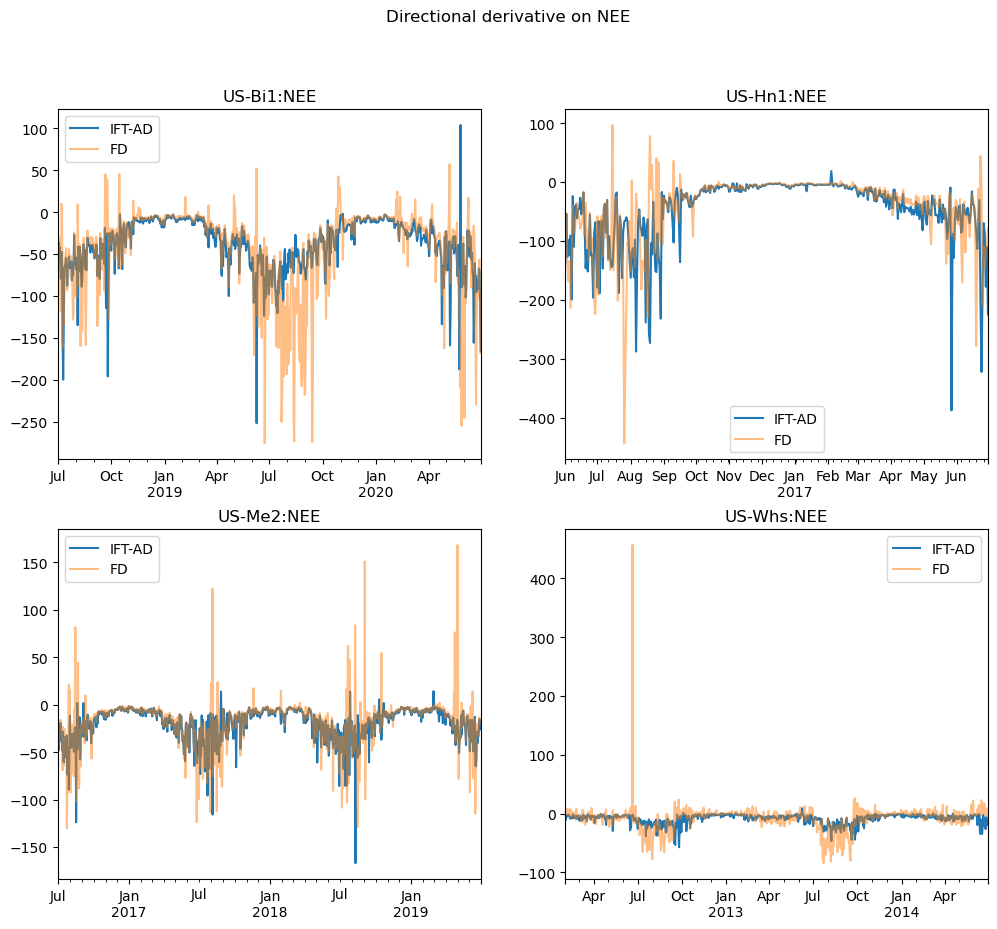

In [8]:
# case = 'PB-1L-0.5'
case = "test-model"
for varn in varn_set:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    for i, site in enumerate(sites):
        ax = axes[i]
        ad = df_sa_set[site][f"{varn}:{case}"]["IFT-AD"].resample("D").mean()
        fd = df_sa_set[site][f"{varn}:{case}"]["FD"].resample("D").mean()
        # ad[np.abs(ad) > 1e5] = np.nan
        ad.plot(ax=ax, label="IFT-AD")
        fd.plot(ax=ax, alpha=0.5, label="FD")
        ax.set(title=f"{site}:{varn}")
        ax.legend()
        plt.suptitle(f"Directional derivative on {varn}")